# I think we can just use the default evals? Because the architecture is the same? just some dataset chagnes?

In [70]:
#let's get the eval class and import the other
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import argparse
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import JointMaskingDecoder
from src.tasks.encoders import JointCNNWithCTT
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
# import seaborn as sns
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                #  data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69). Lets you access a new celltype or just subset to a smaller set of celltypes
                #  sequences_bed_file=None,
                 ) -> None:
        #TODO make it so that we can take in arbitrary dataset information in like a dict and adds options to dataset
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        if self.cfg['train'].get('custom_metric', None) == 'ce_loss_mask_acc': #makes sure we never do softplus in the loss if it's a categorical model!
            self.skip_softplus=True
        else:
            self.skip_softplus=False
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # if data_idxs is not None:
            #     dataset_args['data_idxs'] = data_idxs
            # if sequences_bed_file is not None:
            #     dataset_args['sequences_bed_file'] = sequences_bed_file
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = JointMaskingDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.cfg['encoder']['celltypes'] = 7 #hardcoding for now because it becomes 1 when we use the npz file
        self.encoder = JointCNNWithCTT(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc,ctt),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            ctt = ctt.unsqueeze(0)
        else:
            x,y,ctt,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
                ctt = ctt.unsqueeze(0)
        
        x,y = x.to(self.device), y.to(self.device)
        ctt = ctt.to(self.device)
        
        with torch.no_grad():
            # print(x.shape, y.shape, ctt.shape)
            # print(ctt) #is indeed 6
            x1 = self.encoder(x,y,ctt)
            # print(torch.allclose(x1[0,:,0], self.encoder.ctt_embedding(ctt))) #is indeed true!!
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
    def freeze(self):
        '''freezes the model, so that it doesn't update the weights during training'''
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
    
    def mask(self, start=None, stop=None, idx=None, data=None, run=True,
             mask_accessibility=False, mask_sequence=False,
             randomize_sequence=False, randomize_accessibility=False,
             start_acc=None, stop_acc=None, ctt_val=None
             ):
        '''given an index for the dataset, or just the data, it can mask the data that you want, then runs it through the model, lots of options like to mask accessibility or sequence etc.
        If you don't mask anything, then it's like seeing how confident the model is. But it can mask out regions and see that
        
        Args:
            start (int): the start index to mask, if None requires you don't randomize or mask anything
            stop (int): the end index to mask, if None requires you don't randomize or mask anything
            idx (int, optional): the index of the data in the dataset to use. If None, data must be provided. Defaults to None.
            data (tuple, optional): the data to use, in the form of (x,y,seq_unmask,acc_unmask). If None, idx must be provided. Defaults to None.
            run (bool, optional): whether to run the model on the masked data. If False, it will just return the masked data. Defaults to True.
            mask_accessibility (bool, optional): whether to mask the accessibility values. Defaults to False.
            mask_sequence (bool, optional): whether to mask the sequence values. Defaults to False.
            randomize_sequence (bool, optional): whether to randomize the sequence values instead of masking them. Defaults to False.
            randomize_accessibility (bool, optional): whether to randomize the accessibility values instead of masking them. Defaults to False.
            start_acc (int, optional): the start index to randomize the accessibility values. If None, defaults to start
            stop_acc (int, optional): the end index to randomize the accessibility values. If None, defaults to stop
            
        Returns:
            seq_out (torch.Tensor): the output sequence after running the model, if run is True.
            acc_out (torch.Tensor): the output accessibility after running the model, if run is True.
            seq_unmask_out (torch.Tensor): the original unmasked sequence, if run is True.
            acc_unmask_out (torch.Tensor): the original unmasked accessibility, if run is True.
            x (torch.Tensor): the input sequence after masking, if run is True.
            y (torch.Tensor): the input accessibility after masking, if run is True.
        '''
        if data is not None:
            (x,y,seq_unmask,acc_unmask) = data
        elif idx is not None:
            (x,y),(seq_unmask,acc_unmask) = self.dataset[idx]
        else:
            raise ValueError("Must provide either idx or data")
        
        #now mask the data
        seq = seq_unmask.clone().transpose(1,0) #now is N x length
        acc = acc_unmask.clone().transpose(1,0)
        acc[-1] = 0
        seq[-1] = 0 #zero out the mask so it runs unmasked
        
        if start_acc is None:
            start_acc = start
            stop_acc = stop
        
        if randomize_accessibility:
            random_start = np.random.randint(0, acc.shape[1] - (stop_acc-start_acc)-1) #doesn't include the end point
            acc[0,start:stop] = acc[0,random_start:random_start+(stop_acc-start_acc)]
        
        if mask_accessibility:
            acc[-1, start_acc:stop_acc] = 1 #tells the model it's masked
            acc[0, start_acc:stop_acc] = 0 #zero out the original accessibility values
            
        if randomize_sequence:
            random_indices = torch.randint(0, 4, size=(stop-start,))
            seq[:4,start:stop] = torch.nn.functional.one_hot(random_indices, num_classes=4).transpose(1,0)
            
        if mask_sequence:
            seq[-1,start:stop] = 1
            seq[:-1,start:stop] = 0 #zero out the original sequence values
        
        #now we manually define ctt
        ctt = torch.tensor([ctt_val], dtype=torch.long)
        
        if run:
            x = seq.unsqueeze(0).to(self.device)
            y = acc.unsqueeze(0).to(self.device)
            # ctt = ctt.unsqueeze(0).to(self.device)
            data = (x,y,ctt,seq_unmask,acc_unmask)
            seq_out, acc_out, seq_unmask_out, acc_unmask_out = self(data=data)
        
            return seq_out, acc_out, seq_unmask_out, acc_unmask_out, x, y #it returns the values that were used as inputs, so yyou can see the modified inputs as well as th eoriginal data
        
        else:
            #just return the masked data
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            return None, None, seq_unmask, acc_unmask, x, y

In [71]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals as Evals2

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt'
eval_ctt = Evals(ckpt_path, load_data=False)
print(len(eval_ctt.dataset))

#and now the normal one
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-28/22-15-50-972421/checkpoints/15-val_loss=0.16640.ckpt'
evals = Evals2(ckpt_path, load_data=False)
print(len(evals.dataset))

replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=7, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434
replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=None, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434


In [72]:
#and now the real model, multitask one
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-10-26/14-28-02-720402/checkpoints/02-val_loss=0.22860.ckpt'
evals_multi = Evals2(ckpt_path, load_data=False)
print(len(evals_multi.dataset))

JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937


In [4]:
#see lots of differences in model and things like that, let's see if we get an output tho?
out = evals_multi(0)

In [5]:
out[0].shape

torch.Size([1, 524288, 5])

In [6]:
out[1].shape

torch.Size([1, 524288, 674])

In [73]:
import pandas as pd
enf_targets = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/targets_enformer.txt', sep='\t')
#now we need to get these rows evals.dataset.data_idxs

ctt_labels = []
for idx in evals.dataset.data_idxs:
    print(idx)
    ctt_labels.append(enf_targets.iloc[idx,7].split(':')[1])

457
177
354
120
522
392
12


Text(0.5, 0.98, 'base model')

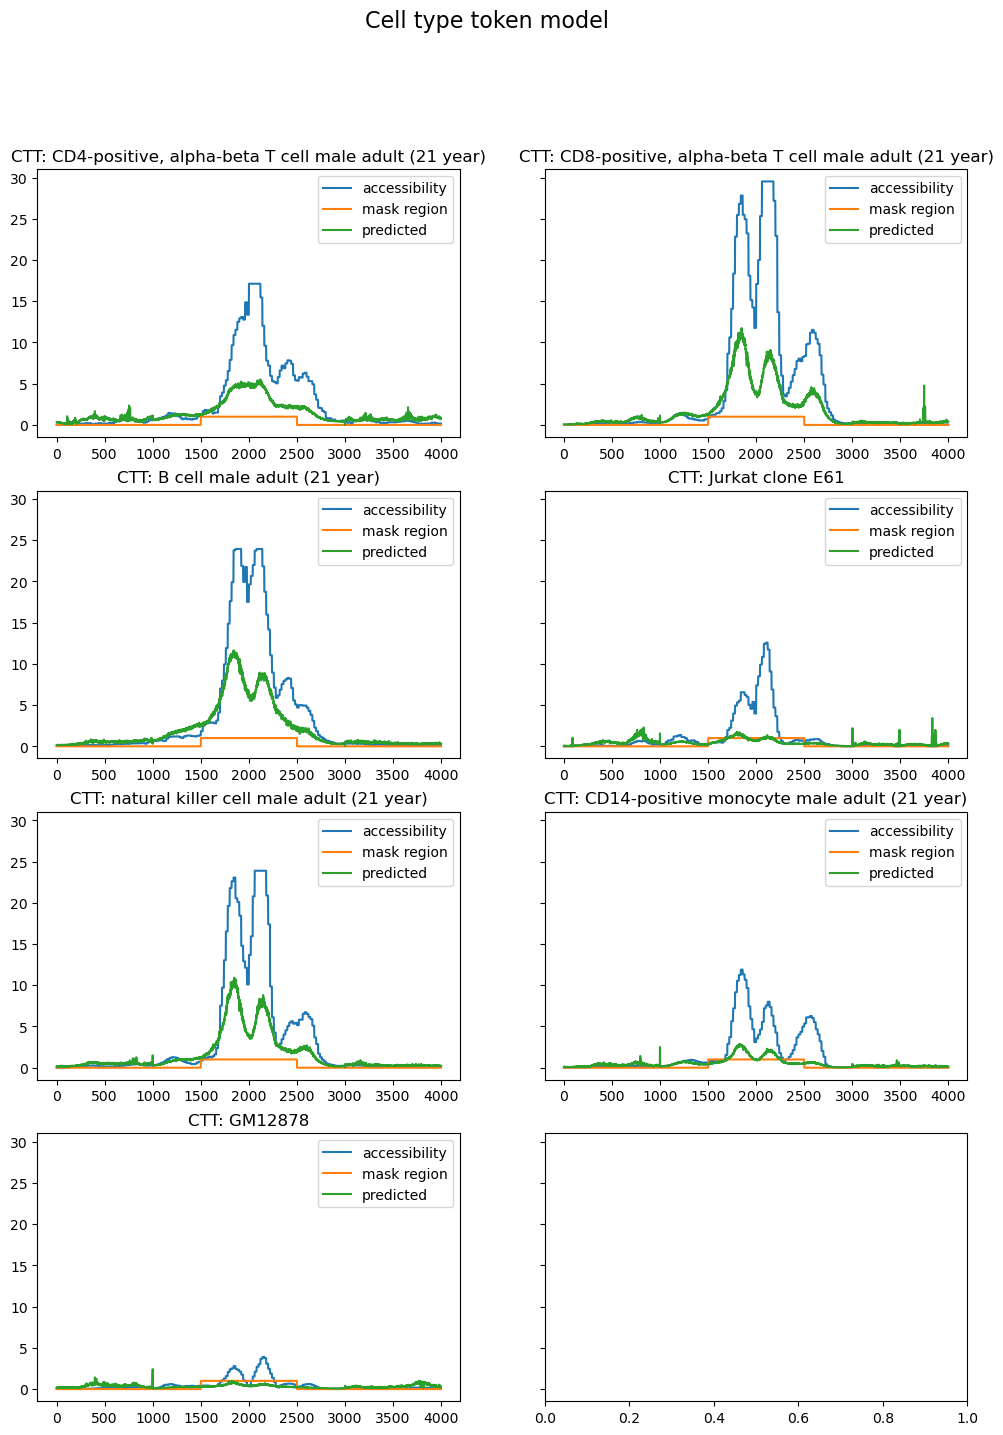

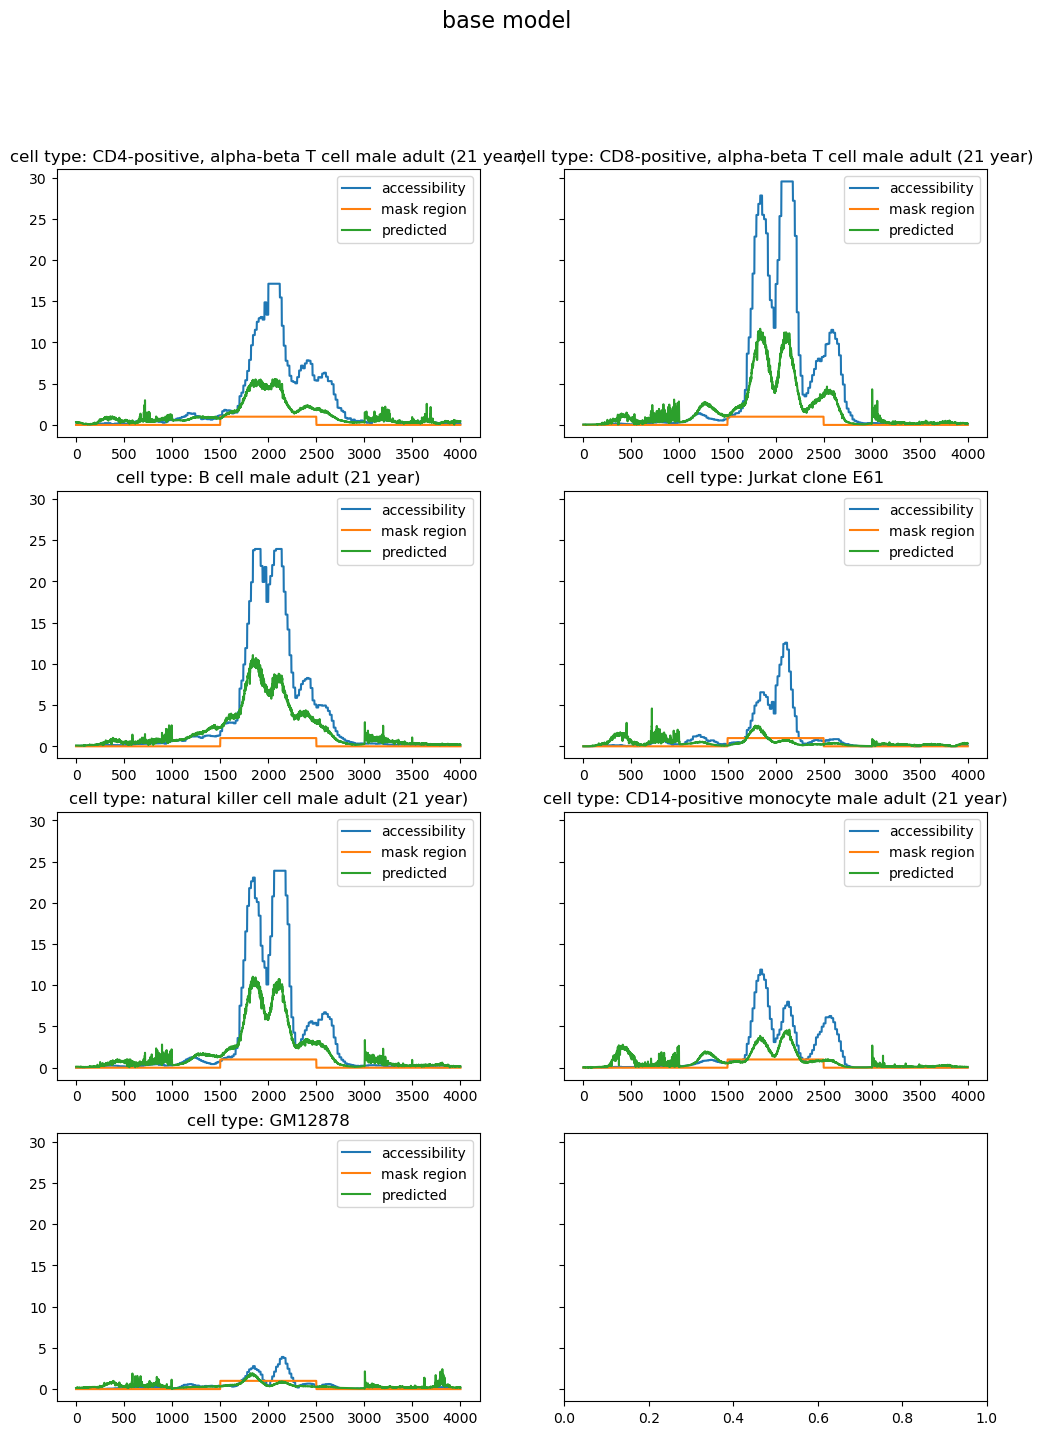

In [8]:
#ok that's exactly as we'd expect, now we can redo some of the ctt plots, but with multitasking??

idxs = [50 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000


fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    #change this so now not 220:225 but relative to max index
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

#and repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)

In [9]:
evals_multi.cfg['dataset']

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/dnase_chunkchrom_reprocessed.zarr',
 'length': 524288,
 'shift_sequences': 1000,
 'load_in': False,
 'rc_aug': True,
 'mlm': 0,
 'acc_mlm': 0.25,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'sequences_bed_file': '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
 'mask_only': True,
 'mask_tie': 0.99,
 'multitasking': True,
 'split': 'test',
 'evaluating': True}

In [10]:
evals.dataset.data_idxs

array([457, 177, 354, 120, 522, 392,  12])

In [11]:
#and let's get it working for the multitask model
mult_idxs = evals.dataset.data_idxs

In [12]:
x,(su,au) = evals.dataset[idxs[0]]
au.shape

torch.Size([524288, 2])

In [13]:
#let's now ensure that the mask works as we expect!

x,(su,au) = evals_multi.dataset[idxs[0]]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True, run=False)

In [14]:
au.shape

torch.Size([524288, 1348])

In [15]:
acc = out1[-1]
acc.shape

torch.Size([1, 1348, 524288])

In [16]:
#ok not pooled yet either is good, but why 1348 outputs? oh the mask lol. Which means we need to mask out just the first half?

acc[0,:,200_000] #yup the first half is the actual values lol. 

tensor([0.1892, 0.1025, 0.0412,  ..., 0.0000, 0.0000, 0.0000])

In [21]:
len(evals_multi.dataset)

1937

In [22]:
len(evals.dataset)

7434

In [24]:
1937*7

13559

In [ ]:
#oh, it's using different splits... let's do the append method?

In [18]:
#ok now we can plot it since we fixed the masking code
# fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
# axs = axs.flatten()
x,(su,au) = evals_multi.dataset[idxs[0]]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)

out1[1].shape

torch.Size([1, 524288, 674])

In [19]:
au.shape

torch.Size([524288, 1348])

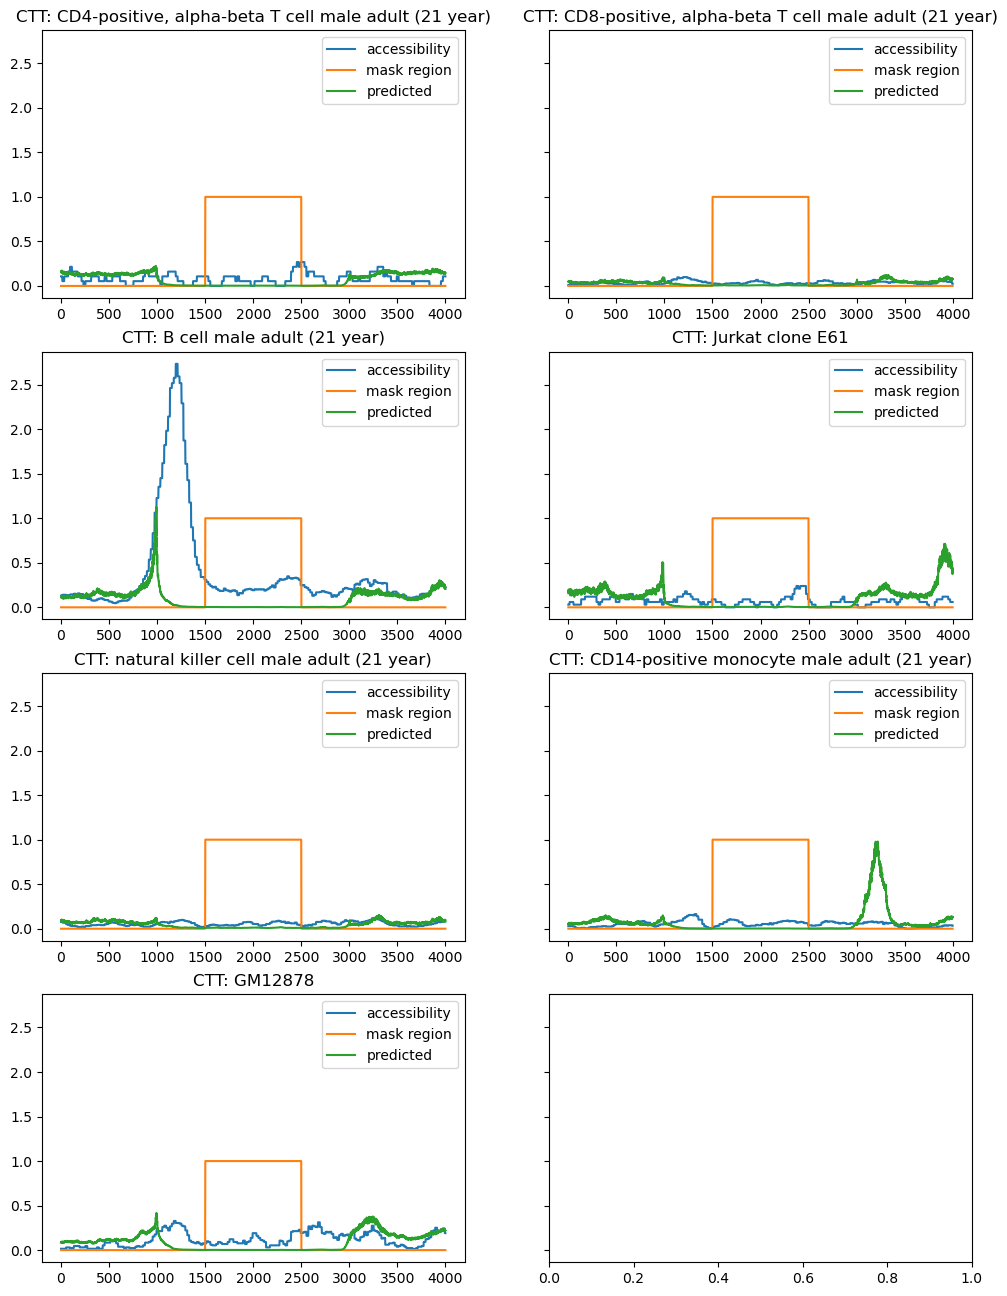

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()

In [28]:
evals.dataset.sequences.iloc[idxs[0]]

0        chr4
1    13107200
2    13631488
3        test
Name: 50, dtype: object

In [74]:
#ok, so let's append these values on and then do it that way?
expand_info = evals.dataset.sequences.iloc[idxs[0]]
newidx = evals_multi.dataset.expand_seqs(expand_info[0], expand_info[1], expand_info[2])

In [32]:
x,(su,au) = evals_multi.dataset[newidx]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)


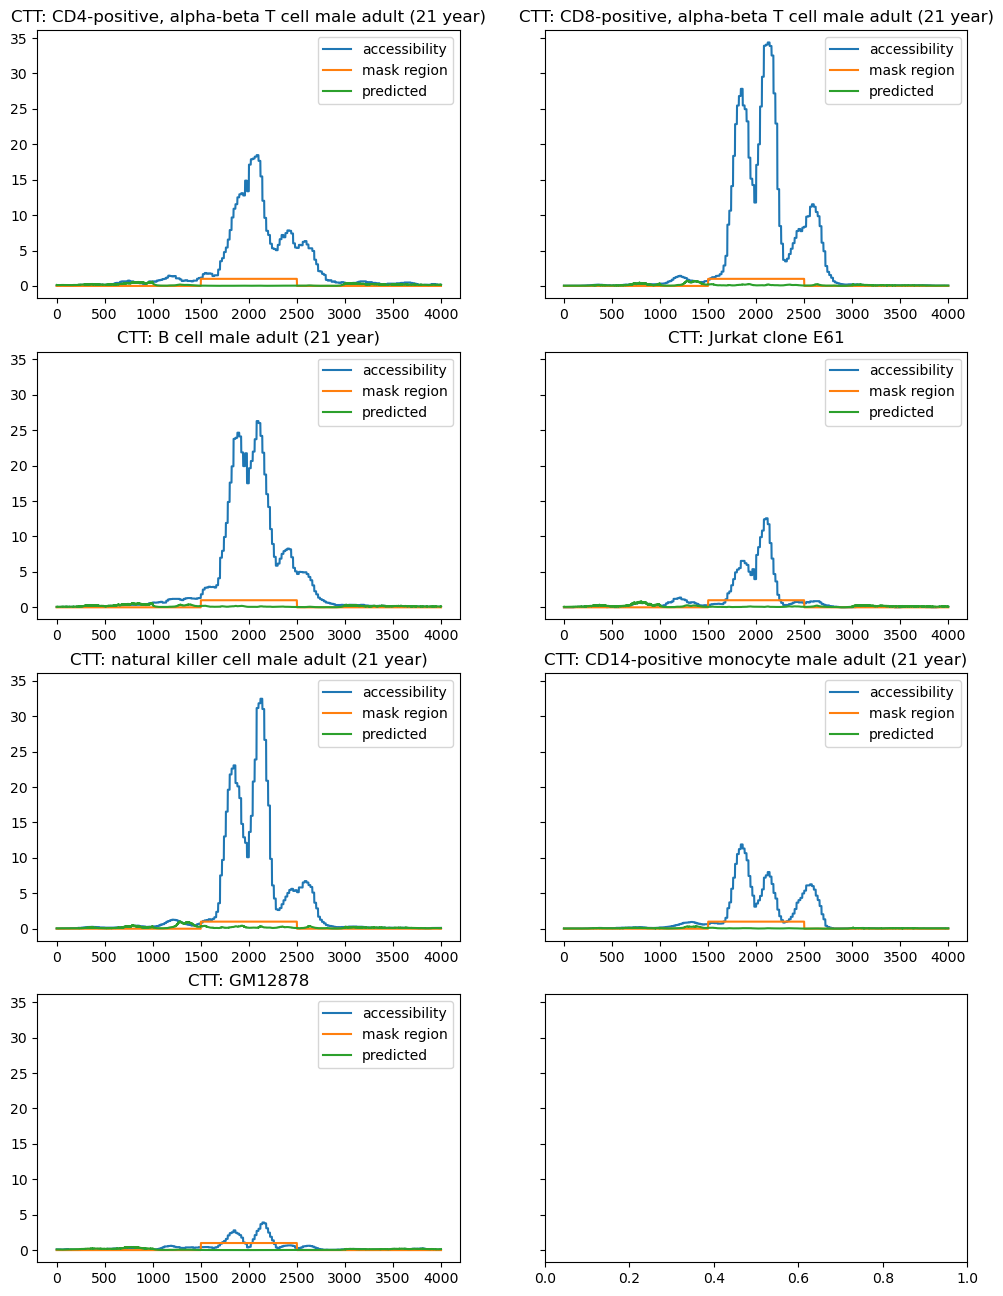

In [33]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()

In [ ]:
out[1].shape #the shape is right, why all so small values?

torch.Size([1, 524288, 674])

In [ ]:
out[1].max() #has some big values too??

tensor(33.2483, device='cuda:0')

In [39]:
#but maybe only where it's shown, not if it's masked??
#make sure au is proper
au.shape

torch.Size([524288, 1348])

In [40]:
au[si:se].shape

torch.Size([2000, 1348])

In [ ]:
au[si:se].max() #it should not be 35... or it should be? yeah it actually should! That's the values we see!!

tensor(34.7500)

In [42]:
#but let's see if the masking is working properly?
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True,run=False,)
acc = out1[-1]

In [43]:
acc.shape

torch.Size([1, 1348, 524288])

In [ ]:
acc[0,:,si:se].max() #ok this looks right??

tensor(1.)

In [45]:
acc[0,:674,si:se].max()

tensor(0.)

In [46]:
acc[0,674:,si:se].min()

tensor(1.)

In [47]:
#ok so the masking is working properly. Maybe it's used to seeing at least one or 2 examples from the other cell types and using that information? I am quite unsure. .REgardless, maybe a bug? Have to revisit the model and make sure it's training properly
#like why would it be so bad? Maybe not trained enough?
#let's just plot the output of multitasking model again

out = evals_multi(0)
out[1].shape #the shape is right, why all so small values?

torch.Size([1, 524288, 674])

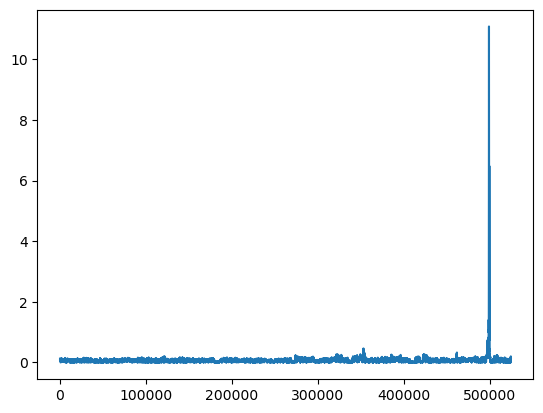

In [ ]:
plt.plot(out[1][0,:,0].cpu().numpy())

In [ ]:
#clearly here it finds a peak, let's see the data
data = evals_multi.dataset[0]
data = (data[0][0], data[0][1], data[1][0], data[1][1])
out = evals_multi(data=data)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [56]:
data[3].shape

torch.Size([524288, 1348])

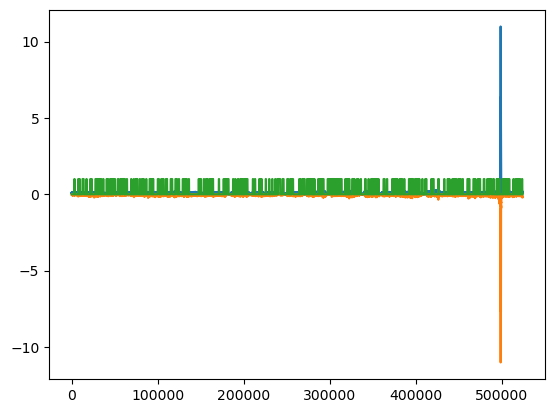

In [59]:
plt.plot(out[1][0,:,0].cpu().numpy())
plt.plot(-1*data[3][:,0].cpu().numpy())
plt.plot(data[3][:,0+674].cpu().numpy())

In [60]:
evals_multi.dataset.sequences

,0,1,2,3
0,chr10,37555537,37686609,test
1,chr14,87048845,87179917,test
2,chrX,136527085,136658157,test
3,chr11,34042349,34173421,test
4,chr19,10352757,10483829,test
...,...,...,...,...
1934,chr19,30681544,30812616,test
1935,chr14,61473198,61604270,test
1936,chr2,129664471,129795543,test
1937,chr4,13107200,13631488,test


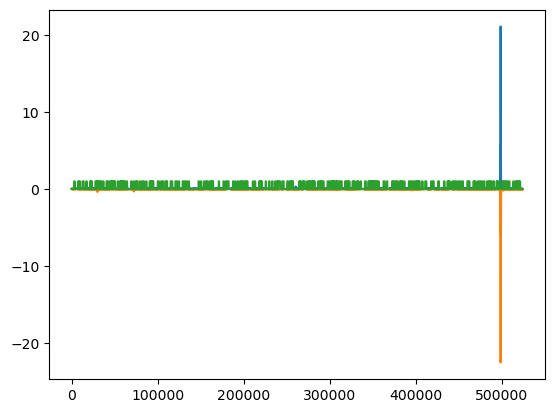

In [66]:
#let's look at some other celltypes
ct = 100
plt.plot(out[1][0,:,ct].cpu().numpy())
plt.plot(-1*data[3][:,ct].cpu().numpy())
plt.plot(data[3][:,ct+674].cpu().numpy())

In [ ]:
#ok for this example it does indeed find it
#but is it just because the mask tie isn't 1? do we need mask tie to be even higher so it is just finding one cell type and predicting the same regardless? but then if we have nothing, it's ass??

In [67]:
#let's look at our actual thing if we don't have it all masked, can it predict well??
data = evals_multi.dataset[newidx]
data = (data[0][0], data[0][1], data[1][0], data[1][1])
out = evals_multi(data=data)


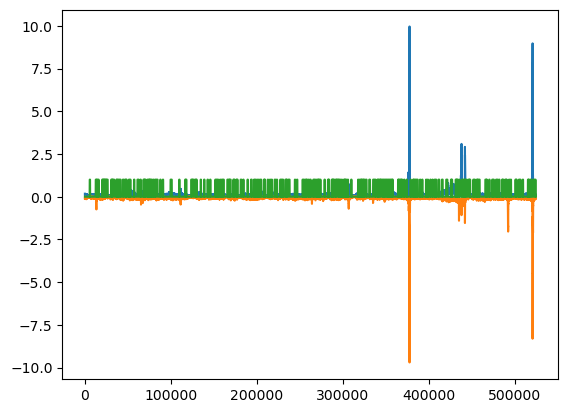

In [ ]:
plt.plot(out[1][0,:,0].cpu().numpy())
plt.plot(-1*data[3][:,0].cpu().numpy())
plt.plot(data[3][:,0+674].cpu().numpy())

#yess see it's completely fine?? but when we mask all values it becomes bad. YEah, ok I get it now...

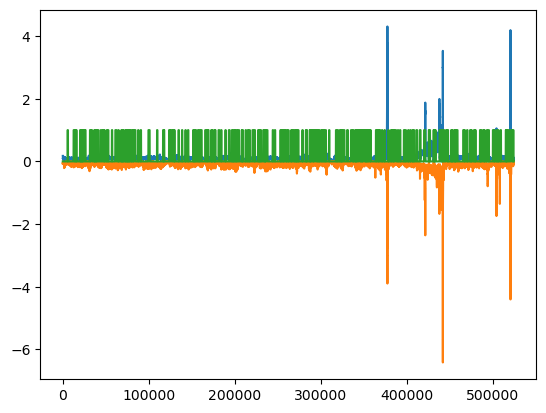

In [69]:
ct = 12
plt.plot(out[1][0,:,ct].cpu().numpy())
plt.plot(-1*data[3][:,ct].cpu().numpy())
plt.plot(data[3][:,ct+674].cpu().numpy())

In [ ]:
#ok so maybe the mask tie is a bit too low? nothing else makes sense...

In [79]:
#let's see this now
data = evals_multi.dataset[newidx]
data = (data[0][0], data[0][1], data[1][0], data[1][1])

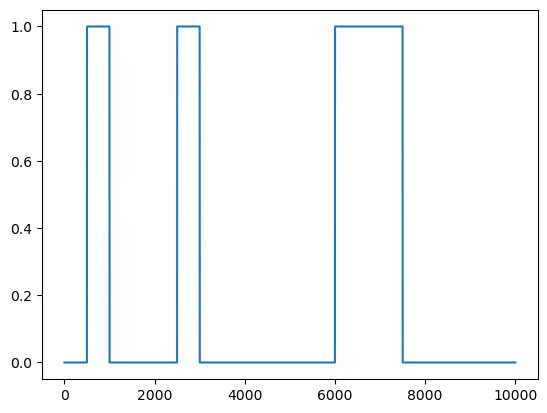

In [82]:
#let's plot the mask
ct = 12
plt.plot(data[3][400_000:410_000,ct+674].cpu().numpy())


In [ ]:
#so seems like the 500 to 1000 is masked, let's test
data[3][400_500:401_000,ct+674].min() #yyes it is masked

tensor(1.)

In [ ]:
data[3][400_500:401_000,674:].min()
#but too many values are unmasked, mask tie is too low...

tensor(0.)

In [85]:
#what if we change it
evals_multi.dataset.mask_tie = 0.999
data = evals_multi.dataset[newidx]

In [86]:
data = (data[0][0], data[0][1], data[1][0], data[1][1])

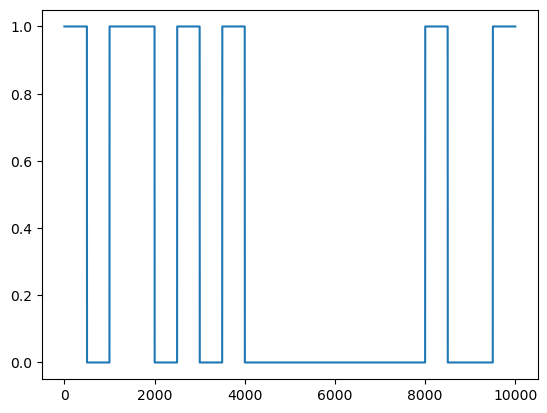

In [87]:
plt.plot(data[3][400_000:410_000,ct+674].cpu().numpy())


In [90]:
#now it's the 400000 to 405000 that is masked, let's see if that's true
data[3][400_000:400_500,ct+674].min()

tensor(1.)

In [91]:
data[3][400_000:400_500,674:].min()

tensor(1.)

In [ ]:
#ok so I will train a model with low mask tie. Also then change the mask tie to first be which peaks will be changed or just unmasked, and then that percent of the tracks are unmasked.
#that's much more straightforward. Right now, I believe it's taking that many tracks and changing some percent of the values? I am quite confused tbh...
#oh right now it's looping over every track, then changing X% of the values in that track. What we should be doing is choosing X% of the masked values, then changing X percent of those values in a few tracks.

In [ ]:
#yeah so make it so that for X% of the masked values, 10% of the tracks are unmasked, but it's a small percent, so can't rely on it, but can still learn from it
#otherwise wsill just use the surrounding peaks to guess lol. Cheating!!

# we changed it, let's see the new models

In [1]:
#get the ctt stuff
#let's get the eval class and import the other
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import argparse
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import JointMaskingDecoder
from src.tasks.encoders import JointCNNWithCTT
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
# import seaborn as sns
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                #  data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69). Lets you access a new celltype or just subset to a smaller set of celltypes
                #  sequences_bed_file=None,
                 ) -> None:
        #TODO make it so that we can take in arbitrary dataset information in like a dict and adds options to dataset
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        if self.cfg['train'].get('custom_metric', None) == 'ce_loss_mask_acc': #makes sure we never do softplus in the loss if it's a categorical model!
            self.skip_softplus=True
        else:
            self.skip_softplus=False
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # if data_idxs is not None:
            #     dataset_args['data_idxs'] = data_idxs
            # if sequences_bed_file is not None:
            #     dataset_args['sequences_bed_file'] = sequences_bed_file
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = JointMaskingDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.cfg['encoder']['celltypes'] = 7 #hardcoding for now because it becomes 1 when we use the npz file
        self.encoder = JointCNNWithCTT(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc,ctt),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            ctt = ctt.unsqueeze(0)
        else:
            x,y,ctt,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
                ctt = ctt.unsqueeze(0)
        
        x,y = x.to(self.device), y.to(self.device)
        ctt = ctt.to(self.device)
        
        with torch.no_grad():
            # print(x.shape, y.shape, ctt.shape)
            # print(ctt) #is indeed 6
            x1 = self.encoder(x,y,ctt)
            # print(torch.allclose(x1[0,:,0], self.encoder.ctt_embedding(ctt))) #is indeed true!!
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
    def freeze(self):
        '''freezes the model, so that it doesn't update the weights during training'''
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
    
    def mask(self, start=None, stop=None, idx=None, data=None, run=True,
             mask_accessibility=False, mask_sequence=False,
             randomize_sequence=False, randomize_accessibility=False,
             start_acc=None, stop_acc=None, ctt_val=None
             ):
        '''given an index for the dataset, or just the data, it can mask the data that you want, then runs it through the model, lots of options like to mask accessibility or sequence etc.
        If you don't mask anything, then it's like seeing how confident the model is. But it can mask out regions and see that
        
        Args:
            start (int): the start index to mask, if None requires you don't randomize or mask anything
            stop (int): the end index to mask, if None requires you don't randomize or mask anything
            idx (int, optional): the index of the data in the dataset to use. If None, data must be provided. Defaults to None.
            data (tuple, optional): the data to use, in the form of (x,y,seq_unmask,acc_unmask). If None, idx must be provided. Defaults to None.
            run (bool, optional): whether to run the model on the masked data. If False, it will just return the masked data. Defaults to True.
            mask_accessibility (bool, optional): whether to mask the accessibility values. Defaults to False.
            mask_sequence (bool, optional): whether to mask the sequence values. Defaults to False.
            randomize_sequence (bool, optional): whether to randomize the sequence values instead of masking them. Defaults to False.
            randomize_accessibility (bool, optional): whether to randomize the accessibility values instead of masking them. Defaults to False.
            start_acc (int, optional): the start index to randomize the accessibility values. If None, defaults to start
            stop_acc (int, optional): the end index to randomize the accessibility values. If None, defaults to stop
            
        Returns:
            seq_out (torch.Tensor): the output sequence after running the model, if run is True.
            acc_out (torch.Tensor): the output accessibility after running the model, if run is True.
            seq_unmask_out (torch.Tensor): the original unmasked sequence, if run is True.
            acc_unmask_out (torch.Tensor): the original unmasked accessibility, if run is True.
            x (torch.Tensor): the input sequence after masking, if run is True.
            y (torch.Tensor): the input accessibility after masking, if run is True.
        '''
        if data is not None:
            (x,y,seq_unmask,acc_unmask) = data
        elif idx is not None:
            (x,y),(seq_unmask,acc_unmask) = self.dataset[idx]
        else:
            raise ValueError("Must provide either idx or data")
        
        #now mask the data
        seq = seq_unmask.clone().transpose(1,0) #now is N x length
        acc = acc_unmask.clone().transpose(1,0)
        acc[-1] = 0
        seq[-1] = 0 #zero out the mask so it runs unmasked
        
        if start_acc is None:
            start_acc = start
            stop_acc = stop
        
        if randomize_accessibility:
            random_start = np.random.randint(0, acc.shape[1] - (stop_acc-start_acc)-1) #doesn't include the end point
            acc[0,start:stop] = acc[0,random_start:random_start+(stop_acc-start_acc)]
        
        if mask_accessibility:
            acc[-1, start_acc:stop_acc] = 1 #tells the model it's masked
            acc[0, start_acc:stop_acc] = 0 #zero out the original accessibility values
            
        if randomize_sequence:
            random_indices = torch.randint(0, 4, size=(stop-start,))
            seq[:4,start:stop] = torch.nn.functional.one_hot(random_indices, num_classes=4).transpose(1,0)
            
        if mask_sequence:
            seq[-1,start:stop] = 1
            seq[:-1,start:stop] = 0 #zero out the original sequence values
        
        #now we manually define ctt
        ctt = torch.tensor([ctt_val], dtype=torch.long)
        
        if run:
            x = seq.unsqueeze(0).to(self.device)
            y = acc.unsqueeze(0).to(self.device)
            # ctt = ctt.unsqueeze(0).to(self.device)
            data = (x,y,ctt,seq_unmask,acc_unmask)
            seq_out, acc_out, seq_unmask_out, acc_unmask_out = self(data=data)
        
            return seq_out, acc_out, seq_unmask_out, acc_unmask_out, x, y #it returns the values that were used as inputs, so yyou can see the modified inputs as well as th eoriginal data
        
        else:
            #just return the masked data
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            return None, None, seq_unmask, acc_unmask, x, y

In [ ]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals as Evals2
ckpt_path_ctt = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt'
ckpt_path_multitask = '/data1/lesliec/sarthak/caduceus/outputs/2025-11-08/21-37-18-424402/checkpoints/last.ckpt'
ckpt_path_fullmasktie = '/data1/lesliec/sarthak/caduceus/outputs/2025-11-08/11-37-49-899249/checkpoints/last.ckpt'

eval_ctt = Evals(ckpt_path_ctt, load_data=False)
print(len(eval_ctt.dataset))

#and now the normal one
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-28/22-15-50-972421/checkpoints/15-val_loss=0.16640.ckpt'
evals = Evals2(ckpt_path, load_data=False)
print(len(evals.dataset))

#and let's do the multitask models
evals_multi = Evals2(ckpt_path_multitask, load_data=False)
print(len(evals_multi.dataset))
#and the full mask tie one
evals_fullmask = Evals2(ckpt_path_fullmasktie, load_data=False)
print(len(evals_fullmask.dataset))

replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=7, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434
replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=None, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434
JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937
JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937


In [3]:
#yup all of this makes perfect sense lol

import pandas as pd
enf_targets = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/targets_enformer.txt', sep='\t')
#now we need to get these rows evals.dataset.data_idxs

ctt_labels = []
for idx in evals.dataset.data_idxs:
    print(idx)
    ctt_labels.append(enf_targets.iloc[idx,7].split(':')[1])
    
mult_idxs = evals.dataset.data_idxs

457
177
354
120
522
392
12


In [ ]:
mult_idxs #literally the same lol

array([457, 177, 354, 120, 522, 392,  12])

Text(0.5, 0.98, 'base model')

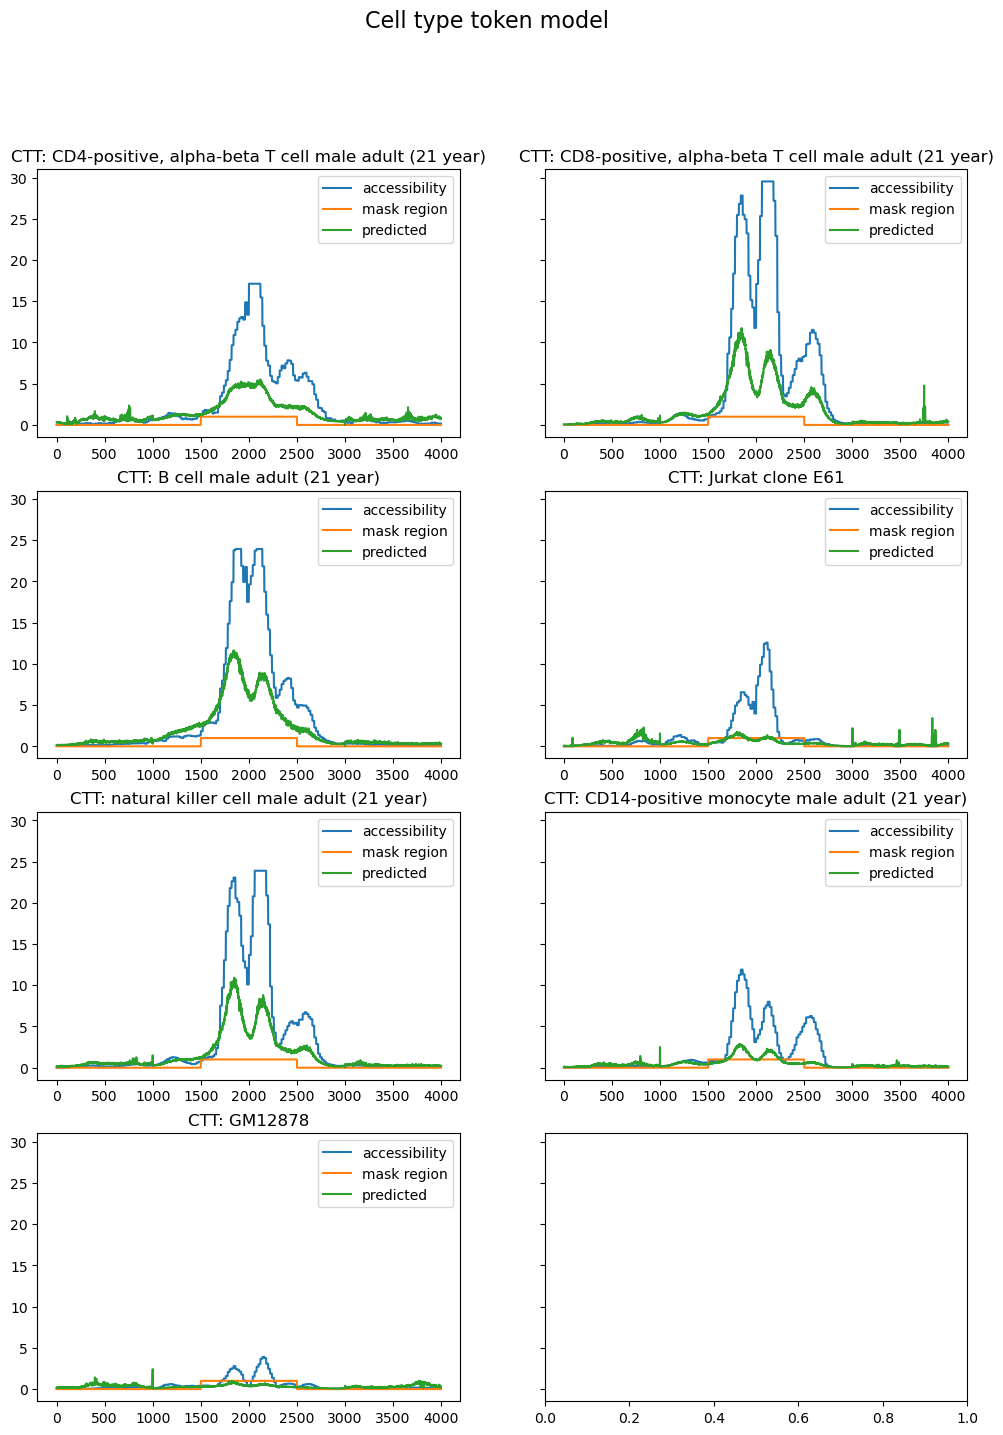

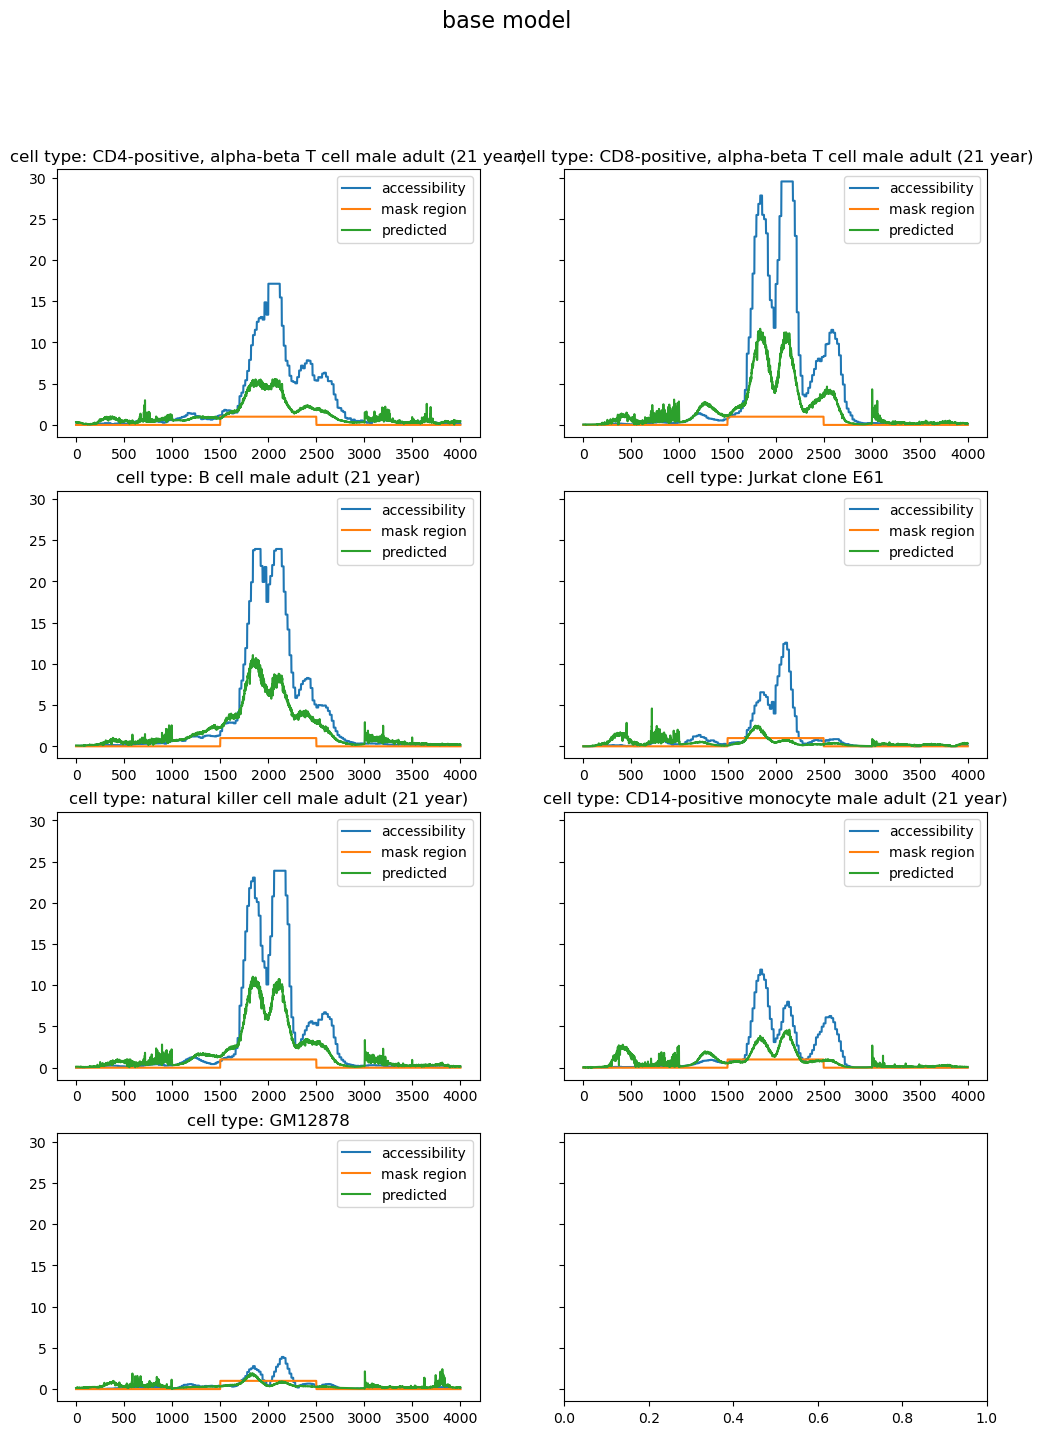

In [6]:
#ok that's exactly as we'd expect, now we can redo some of the ctt plots, but with multitasking??

idxs = [50 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000


fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = eval_ctt.dataset[idx]
    data = (None,None,su,au)
    assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = eval_ctt.mask(si,se,data=data,mask_accessibility=True,ctt_val=i)
    #change this so now not 220:225 but relative to max index
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('Cell type token model', fontsize=16)

#and repeat for the normal model
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(idxs):
    x,(su,au) = evals.dataset[idx]
    data = (None,None,su,au)
    # assert x[2] == i, f"CTT value mismatch for idx {idx}, expected {i}, got {x[2]}"
    out1 = evals.mask(si,se,data=data,mask_accessibility=True)
    axs[i].plot(au[start_plot:end_plot,0], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,0].cpu().numpy(), label='predicted')
    axs[i].set_title(f'cell type: {ctt_labels[i]}')
    axs[i].legend()
#and add a supertitle
fig.suptitle('base model', fontsize=16)

In [5]:
idxs = [50 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = eval_ctt.dataset[idxs[0]]
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000

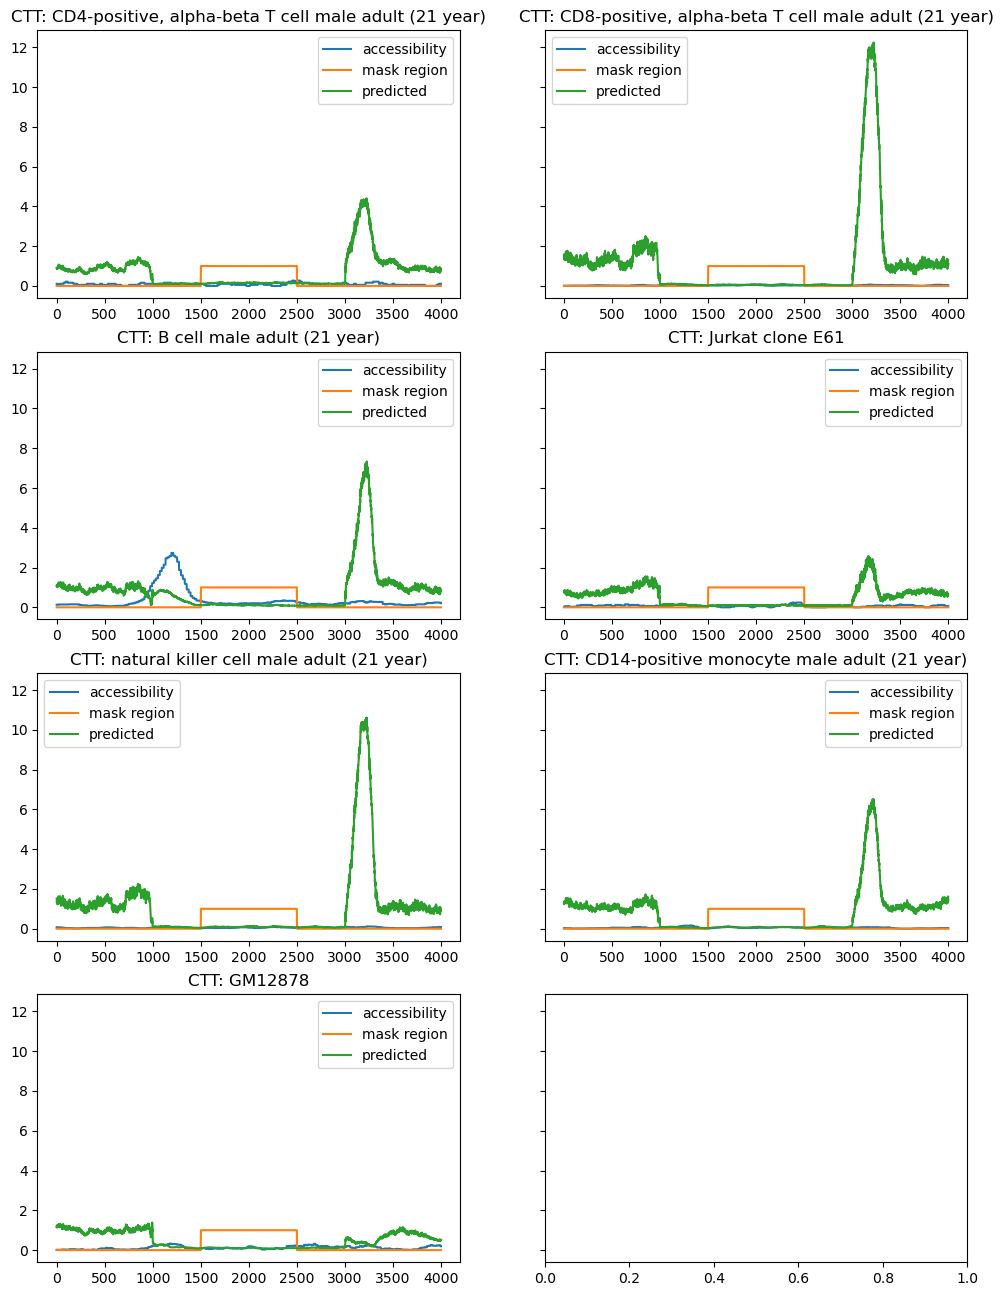

In [10]:
#that's just the same as before, so now let's do it for the multitask model



x,(su,au) = evals_multi.dataset[idxs[0]]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)

fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()

In [13]:
evals_multi.dataset.sequences.iloc[idxs[0]]

0         chr3
1    188059335
2    188190407
3         test
Name: 50, dtype: object

In [14]:
evals.dataset.sequences.iloc[idxs[0]]

0        chr4
1    13107200
2    13631488
3        test
Name: 50, dtype: object

In [15]:
#why tf are they different??
evals_multi.dataset.sequences

,0,1,2,3
0,chr10,37555537,37686609,test
1,chr14,87048845,87179917,test
2,chrX,136527085,136658157,test
3,chr11,34042349,34173421,test
4,chr19,10352757,10483829,test
...,...,...,...,...
1932,chr19,33204702,33335774,test
1933,chr14,41861379,41992451,test
1934,chr19,30681544,30812616,test
1935,chr14,61473198,61604270,test


In [17]:
evals.dataset.sequences

,0,1,2,3
0,chr4,0,524288,test
1,chr4,262144,786432,test
2,chr4,524288,1048576,test
3,chr4,786432,1310720,test
4,chr4,1048576,1572864,test
...,...,...,...,...
1057,chr14,105381888,105906176,test
1058,chr14,105644032,106168320,test
1059,chr14,105906176,106430464,test
1060,chr14,106168320,106692608,test


In [18]:
evals.dataset.sequences.iloc[idxs[0],0]

'chr4'

In [6]:
#oh we used the span one instead of enformer for training that. I guess another difference to increase training speed per epoch? oh well.

#let's do the expand seqs
tempchr,tempstart,tempend,_ = evals.dataset.sequences.iloc[idxs[0]]
idx = evals_multi.dataset.expand_seqs(tempchr, tempstart, tempend)
idx

1937

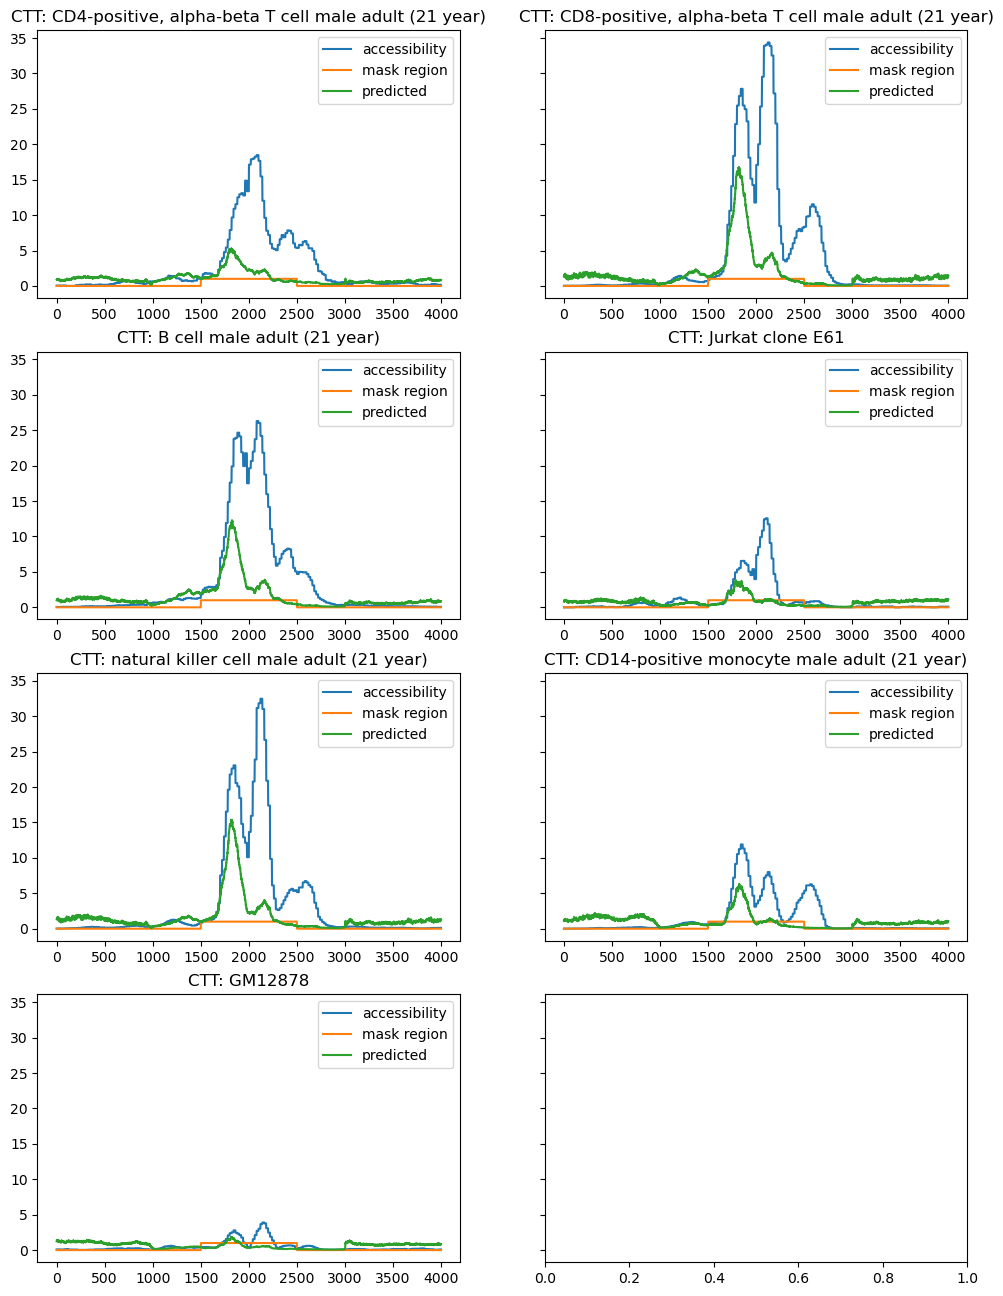

In [7]:
x,(su,au) = evals_multi.dataset[idx]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)

fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx_unused in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()

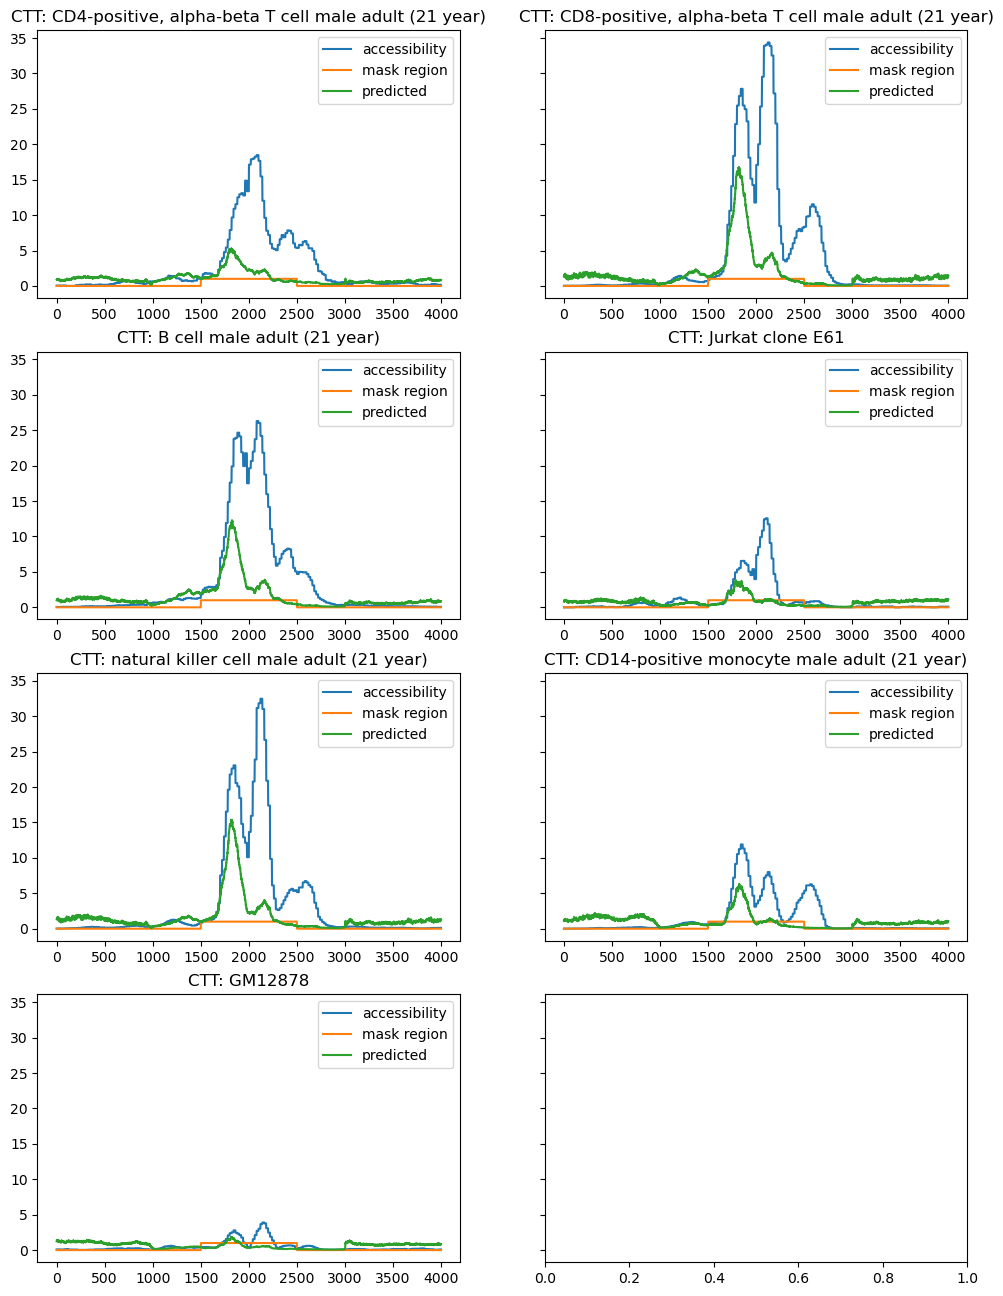

In [10]:
#this region might not even be in the test... let's also check the other full mask model
idx = evals_fullmask.dataset.expand_seqs(tempchr, tempstart, tempend)
x,(su,au) = evals_fullmask.dataset[idx]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)

fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx_unused in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()

In [ ]:
#multitasking does just seem worse... i mean we're multitasking a lot more cell types maybe? let's let it keep training, we won't do full mask tie as it doesn't really seem useful

out1[1].shape

torch.Size([1, 524288, 674])

# more epochs, does this change anything?

In [ ]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals as Evals2
ckpt_path_ctt = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt'
ckpt_path_multitask = '/data1/lesliec/sarthak/caduceus/outputs/2025-11-17/13-28-59-583050/checkpoints/last.ckpt'
ckpt_path_fullmasktie = '/data1/lesliec/sarthak/caduceus/outputs/2025-11-17/13-50-51-596207/checkpoints/last.ckpt'

# eval_ctt = Evals(ckpt_path_ctt, load_data=False)
# print(len(eval_ctt.dataset))

#and now the normal one
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-28/22-15-50-972421/checkpoints/15-val_loss=0.16640.ckpt'
evals = Evals2(ckpt_path, load_data=False)
print(len(evals.dataset))

#and let's do the multitask models
evals_multi = Evals2(ckpt_path_multitask, load_data=False)
print(len(evals_multi.dataset))
#and the full mask tie one
evals_fullmask = Evals2(ckpt_path_fullmasktie, load_data=False)
print(len(evals_fullmask.dataset))

replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=7, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434
replacing cell type number with data indices, 7
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1, upsample=1
JointMaskingEncoder: d_model=256, celltypes=None, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
7434
JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937
JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937


In [ ]:
idxs = [50 + i*1062 for i in range(7)]
#now we need to get a new max index
a,b = evals.dataset[idxs[0]]
max_index = torch.argmax(b[1][:,0])
si = max_index-1000
se = max_index+1000
mask = torch.zeros(b[1].shape)
mask[max_index-500:max_index+500,0] = 1
#also change how it's plotted
start_plot = max_index - 2000
end_plot = max_index + 2000

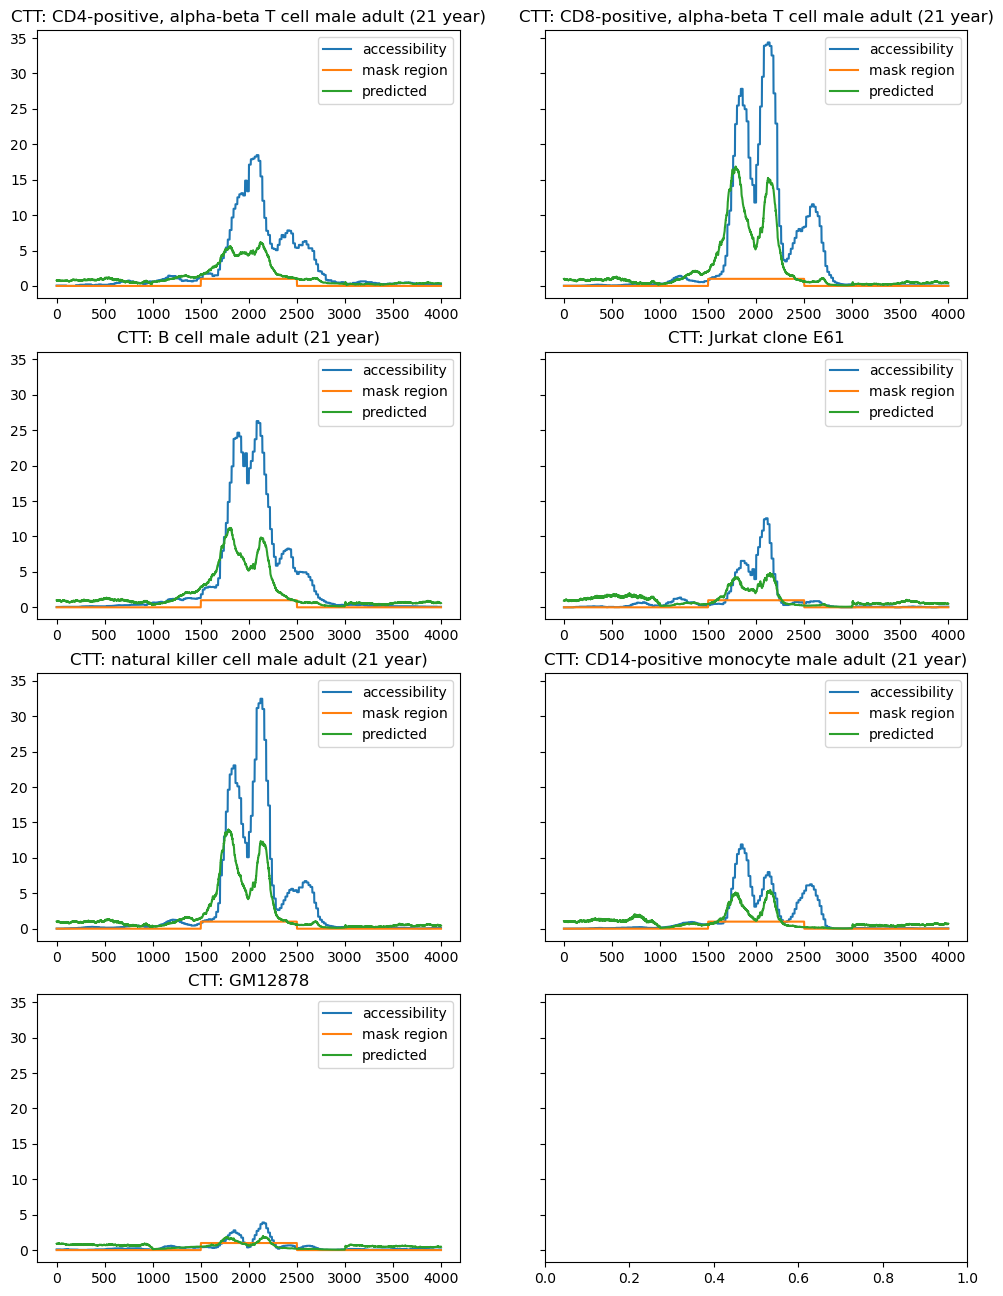

In [ ]:
tempchr,tempstart,tempend,_ = evals.dataset.sequences.iloc[idxs[0]]
idx = evals_multi.dataset.expand_seqs(tempchr, tempstart, tempend)
x,(su,au) = evals_multi.dataset[idx]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)

fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx_unused in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()
    
#I mean it's better, but not a high bar to begin with. Also probably in the trian set?

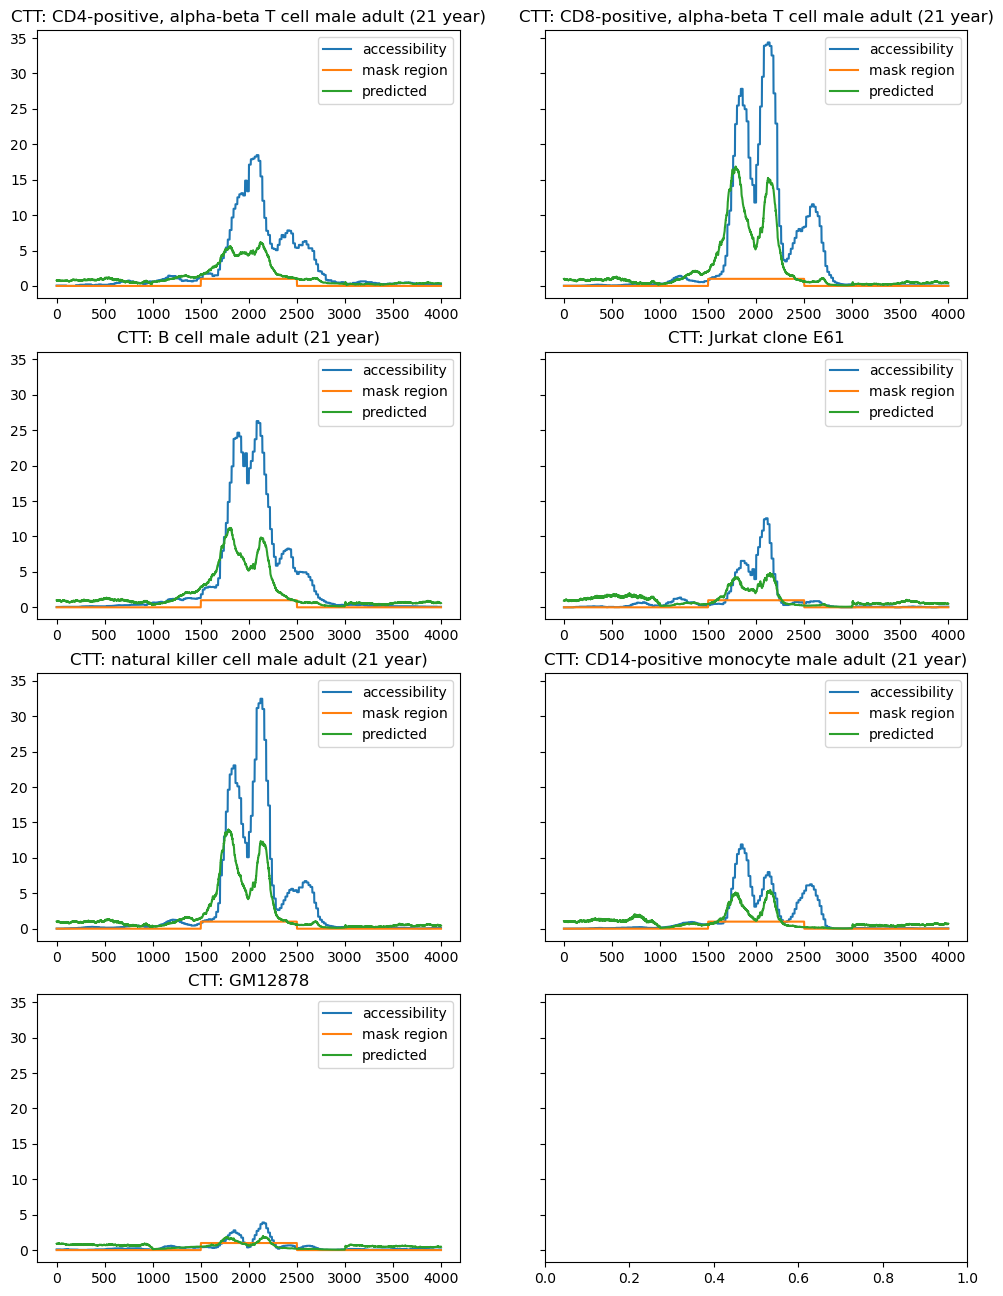

: 

In [ ]:
#and the full mask tie?

idx = evals_fullmask.dataset.expand_seqs(tempchr, tempstart, tempend)
x,(su,au) = evals_fullmask.dataset[idx]
data = (None,None,su,au)
out1 = evals_multi.mask(si,se,data=data,mask_accessibility=True)

fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharey=True)
axs = axs.flatten()

for i,idx_unused in enumerate(idxs):   
    axs[i].plot(au[start_plot:end_plot,mult_idxs[i]], label='accessibility')
    axs[i].plot(mask[start_plot:end_plot,0], label='mask region')
    axs[i].plot(out1[1][0,start_plot:end_plot,mult_idxs[i]].cpu().numpy(), label='predicted')
    axs[i].set_title(f'CTT: {ctt_labels[i]}')
    axs[i].legend()

In [ ]:
#they look basically identical, so ignore the fullmask tie and just do the other one!

# now see how it does VEP

In [1]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals as Evals2
ckpt_path_ctt = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-15/17-49-16-937449/checkpoints/07-val_loss=0.16646.ckpt'
ckpt_path_multitask = '/data1/lesliec/sarthak/caduceus/outputs/2025-11-17/13-28-59-583050/checkpoints/last.ckpt'
ckpt_path_fullmasktie = '/data1/lesliec/sarthak/caduceus/outputs/2025-11-17/13-50-51-596207/checkpoints/last.ckpt'

# eval_ctt = Evals(ckpt_path_ctt, load_data=False)
# print(len(eval_ctt.dataset))

#and now the normal one
# ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-28/22-15-50-972421/checkpoints/15-val_loss=0.16640.ckpt'
# evals = Evals2(ckpt_path, load_data=False)
# print(len(evals.dataset))

#and let's do the multitask models
evals_multi = Evals2(ckpt_path_multitask, load_data=False)
print(len(evals_multi.dataset))
#and the full mask tie one
evals_fullmask = Evals2(ckpt_path_fullmasktie, load_data=False)
print(len(evals_fullmask.dataset))

JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937
JointMaskingDecoder: d_model=1024, d_output1=5, d_output2=674, upsample=8
JointMaskingEncoder: d_model=1024, celltypes=None, d_input1=6, d_input2=1348, joint=False, kernel_size=15, combine=True, acc_type=continuous
1937


In [2]:
import pandas as pd
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
#some other things to load in
import numpy as np
genome = np.load('/data1/lesliec/sarthak/data/chrombpnet_test/hg38_tokenized.npz')
genome_loaded = {}
for key in genome:
    genome_loaded[key] = genome[key][:]

bims = {}
for i in range(1,23):
    bim_path = f'/data1/deyk/extras/1000G_BIMS_hg38/1000G.EUR.QC.{i}.bim'
    bim = pd.read_csv(bim_path, sep='\t', header=None)
    bims[i] = bim
    
bim_pos = {
    chrom: dict(zip(bims[chrom][1].values, bims[chrom][3].index))
    for chrom in bims
}

In [3]:
rsid = qtls.iloc[0]['SNPname2']
chrom = qtls.iloc[0]['chrom_hg19']
bimrow = bim_pos[int(chrom[3:])][rsid]
bimval = bims[int(chrom[3:])].iloc[bimrow]

In [4]:
midpoint = bimval[3]-1
start = midpoint - 524288//2
end = start + 524288

In [5]:
evals_multi.dataset.expand_seqs(chrom,start,end)

1937

In [6]:
data = evals_multi.dataset[1937]

In [7]:
si = 524288//2 - 250
se = 524288//2 + 250

In [8]:
#let's see this and figure out how we will do this
data[0][0].shape, data[0][1].shape, data[1][0].shape, data[1][1].shape

(torch.Size([6, 524288]),
 torch.Size([1348, 524288]),
 torch.Size([524288, 6]),
 torch.Size([524288, 1348]))

In [ ]:
#here's the default
'''
out = evals.mask(si,se, 1937, mask_accessibility=True)
'''

In [9]:
#let's do one where we mask all then predict!
#we'll use the seq just like before
(x,y),(seq_unmask,acc_unmask) = data
seq = seq_unmask.clone().transpose(1,0) #now is N x length
seq[-1] = 0 #zero out the mask so it runs unmasked
seq.sum(1), seq.sum()

(tensor([115927., 145523., 146132., 116706.,      0.,      0.]),
 tensor(524288.))

In [10]:
#no N, no mask, and sums to 524288, perfect, that's the input sequence unmasked!

#now we have to alter the accessibility, but this is obviously much harder

acc = acc_unmask.clone().transpose(1,0) #is again N x length, but this is much harder
acc.nbytes/1e9 #2-3GB!!

2.826960896

In [11]:
acc.sum(1) #it goes all continues values, then the indication of if it's masked or not, let's see if this works

tensor([ 94153.7422, 206543.9688, 378418.9688,  ..., 137000.0000,
        138500.0000, 138500.0000])

In [12]:
acc.shape

torch.Size([1348, 524288])

In [13]:
#so first let's mask just the 1 track. In this case, the track is 12 (GM12878)
ct = 12
#first make sure none of it is masked
acc[1348//2:] = 0
acc.sum(1)

tensor([ 94153.7422, 206543.9688, 378418.9688,  ...,      0.0000,
             0.0000,      0.0000])

In [14]:
#now we will actually mask out the values
acc[12,si:se] = 0 #zero out the original accessibility values
acc[1348//2+12, si:se] = 1 #tells the model it's masked

In [15]:
#now let's input it into the model
x = seq.unsqueeze(0).to(evals_multi.device)
y = acc.unsqueeze(0).to(evals_multi.device)
data = (x,y,seq_unmask,acc_unmask)
seq_out, acc_out, seq_unmask_out, acc_unmask_out = evals_multi(data=data)
seq_out.shape, acc_out.shape

(torch.Size([1, 524288, 5]), torch.Size([1, 524288, 674]))

In [16]:
import torch
torch.allclose(seq_unmask_out, seq_unmask)

True

In [19]:
acc_unmask.shape

torch.Size([524288, 1348])

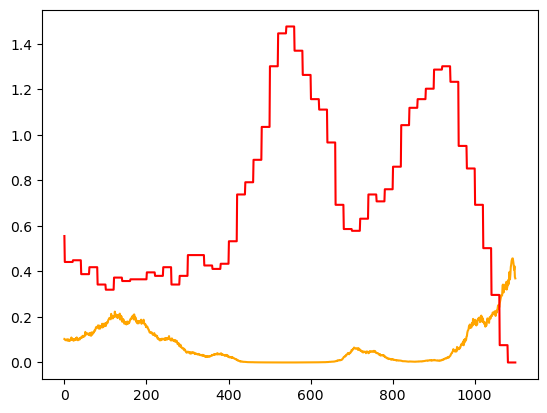

In [20]:
#ok now we can plot it
import matplotlib.pyplot as plt
plt.plot(acc_out[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(acc_unmask[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')
# plt.plot(a[si-300:se+300,0], label='true values', color='green')
# plt.plot(acc_out[0,:,ct].cpu().numpy())
# plt.plot(-1*acc[ct].cpu().numpy())
# plt.plot(acc_unmask[:,ct].cpu().numpy())

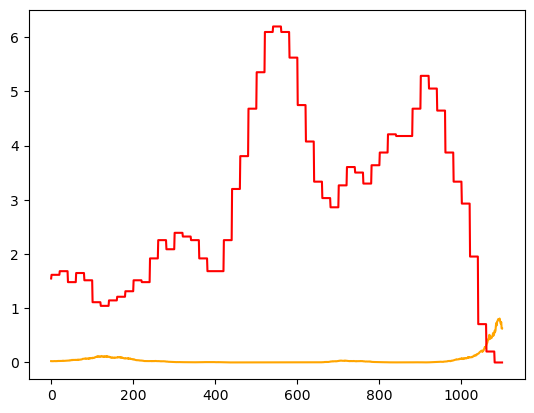

In [ ]:
#let's see the prediction of a different track
plt.plot(acc_out[0,si-300:se+300,13].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(acc_unmask[si-300:se+300, 13].cpu().numpy(), label='Model input', color='red')
#it's not even masked... wtf?

In [22]:
#the true values looks good, but the acc out looks really bad. Let's retry it but this time we'll do literally 0 masking
data = evals_multi.dataset[1937]
(x,y),(seq_unmask,acc_unmask) = data
seq = seq_unmask.clone().transpose(1,0) #now is N x length
acc = acc_unmask.clone().transpose(1,0) #is again N x length, but this is much harder
ct = 12
#first make sure none of it is masked
seq[-1] = 0
acc[1348//2:] = 0

#now just get the output
x = seq.unsqueeze(0).to(evals_multi.device)
y = acc.unsqueeze(0).to(evals_multi.device)
data = (x,y,seq_unmask,acc_unmask)
seq_out, acc_out, seq_unmask_out, acc_unmask_out = evals_multi(data=data)
seq_out.shape, acc_out.shape

# acc[:1348,si:se] = 0 #zero out the original accessibility values
# acc[1348//2+12, si:se] = 1 #tells the model it's masked



(torch.Size([1, 524288, 5]), torch.Size([1, 524288, 674]))

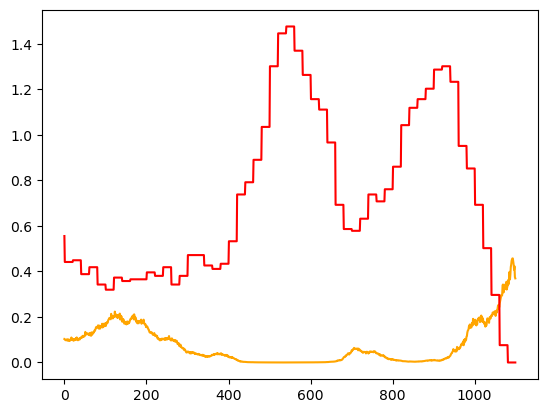

In [23]:
#let's plot it now
plt.plot(acc_out[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(acc_unmask[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')

In [24]:
#why is it still so bad? maybe this peak is just bad? but it's literally not masked, lmao...
s,a,su,au = evals_multi(1937)

In [26]:
a.shape, au.shape

(torch.Size([1, 524288, 674]), torch.Size([524288, 1348]))

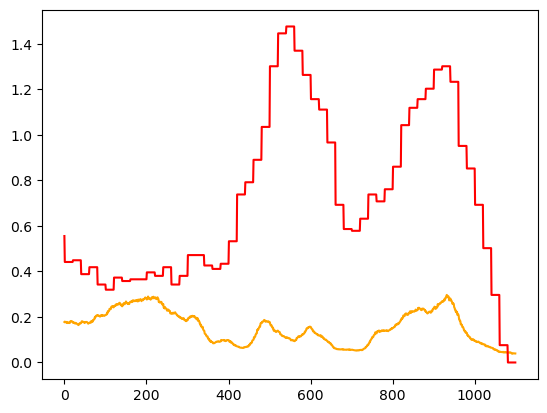

In [27]:
#now let's plot a and au
plt.plot(a[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(au[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')

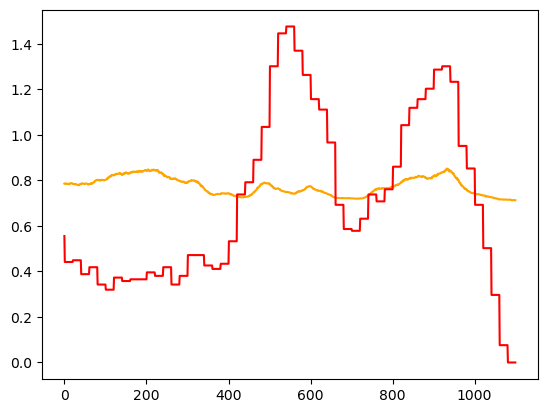

In [30]:
#it's just really bad?
#let's do softplus of a output
a_sp = torch.nn.functional.softplus(a)
plt.plot(a_sp[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(au[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')

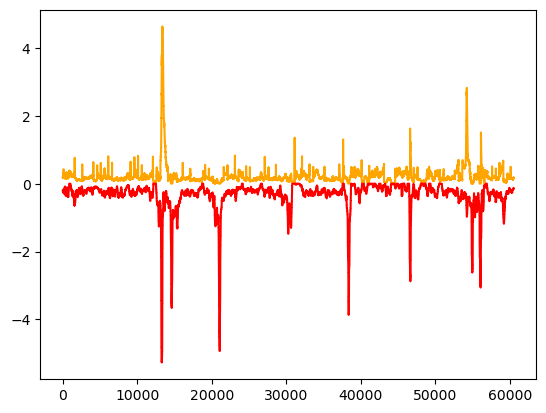

In [ ]:
#huh, I guess this model is just really bad at this peak? let's try another one and see...
plt.plot(a[0,si-30000:se+30000,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(-au[si-30000:se+30000, 12].cpu().numpy(), label='Model input', color='red')
#doesn't need softplus, I guess this model is just not great, particularly this peak, seems almost offset to the left and right? I'm quite confused, but oh well


In [33]:
#could explore the full mask tie model, but I don't think it's worth it...
#but let's just look
evals_fullmask.dataset.expand_seqs(chrom,start,end)

1937

In [34]:
data = evals_fullmask.dataset[1937]
(x,y),(seq_unmask,acc_unmask) = data
seq = seq_unmask.clone().transpose(1,0) #now is N x length
acc = acc_unmask.clone().transpose(1,0) #is again N x length, but this is much harder
ct = 12
#first make sure none of it is masked
seq[-1] = 0
acc[1348//2:] = 0

#now just get the output
x = seq.unsqueeze(0).to(evals_fullmask.device)
y = acc.unsqueeze(0).to(evals_fullmask.device)
data = (x,y,seq_unmask,acc_unmask)
seq_out, acc_out, seq_unmask_out, acc_unmask_out = evals_fullmask(data=data)
seq_out.shape, acc_out.shape

(torch.Size([1, 524288, 5]), torch.Size([1, 524288, 674]))

In [38]:
torch.allclose(y,acc_unmask)

RuntimeError: The size of tensor a (524288) must match the size of tensor b (1348) at non-singleton dimension 2

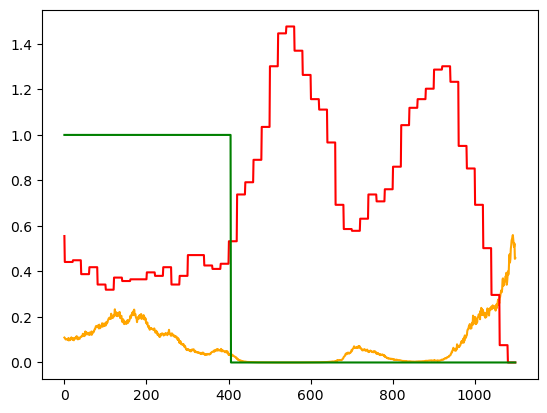

In [43]:
plt.plot(acc_out[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(acc_unmask[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')
plt.plot(acc_unmask[si-300:se+300, 12+1348//2].cpu().numpy(), label='Model input', color='green')

In [36]:
s,a,su,au = evals_fullmask(1937)

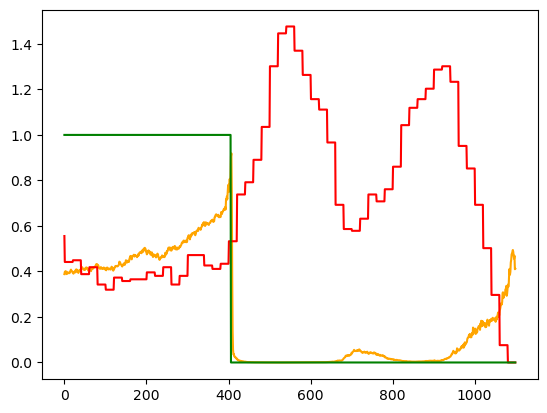

In [42]:
plt.plot(a[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(au[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')
plt.plot(au[si-300:se+300, 12+1348//2].cpu().numpy(), label='Model input', color='green')

In [ ]:
#wait a minute..., maybe it's just out of distribution and is weird? idk dude
acc.shape

torch.Size([1348, 524288])

In [ ]:
acc[1348//2:].sum() #zero so nothing is masked...
#I legtimately have no clue, let's just also make sure to train the full mask tie model I guess to compare...

tensor(0.)

In [ ]:
#we can revisit later, maybe I made a mistake, maybe it's not trained enough, I have absolutely no clue...
#maybe just bad at gm12878, have to explore more celltypes, look more at specific areas it masks, and just explore more, clealry something is wrong...
#can explore how training elements masked and stuff too, lots to do here...

In [44]:
#let's just test it with a full mask tie

data = evals_fullmask.dataset[1937]
(x,y),(seq_unmask,acc_unmask) = data
seq = seq_unmask.clone().transpose(1,0) #now is N x length
acc = acc_unmask.clone().transpose(1,0) #is again N x length, but this is much harder
ct = 12
#first make sure none of it is masked
seq[-1] = 0
acc[1348//2:] = 0
acc[:1348//2,si:se] = 0
acc[1348//2:,si:se] = 1

#now just get the output
x = seq.unsqueeze(0).to(evals_fullmask.device)
y = acc.unsqueeze(0).to(evals_fullmask.device)
data = (x,y,seq_unmask,acc_unmask)
seq_out, acc_out, seq_unmask_out, acc_unmask_out = evals_fullmask(data=data)
seq_out.shape, acc_out.shape

: 

In [ ]:
acc.shape

In [ ]:
plt.plot(acc_out[0,si-300:se+300,12].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(acc_unmask[si-300:se+300, 12].cpu().numpy(), label='Model input', color='red')
plt.plot(acc[si-300:se+300, 12+1348//2].cpu().numpy(), label='Model input', color='green')

In [ ]:
#yeah no clue why, oh well, we can explore it later...